# PyMEOS Demo for ACM Demo

In [2]:
from functools import partial

import pandas as pd
import pyproj
import shapely as shp
from matplotlib import pyplot as plt
from pymeos import *
from pymeos.plotters import TemporalPointSequencePlotter
from shapely.ops import transform
from tqdm.auto import tqdm
import contextily as cx

tqdm.pandas()
pymeos_initialize()

## Preprocessing

In [30]:
raw = pd.read_csv('singapore_selection.csv', header=0,
                  names=['ID', 'Trajectory ID', 'Driving Mode', 'OS Name', 'Timestamp', 'Latitude', 'Longitude',
                         'Speed', 'Bearing', 'Accuracy'],
                  usecols=['ID', 'Trajectory ID', 'Timestamp', 'Latitude', 'Longitude', 'Speed', 'Bearing', 'Accuracy'])
raw.head()

,ID,Trajectory ID,Timestamp,Latitude,Longitude,Speed,Bearing,Accuracy
0,0,70014,1554943236,1.342326,103.888969,18.910000,248,3.9
1,1,73573,1555582623,1.321781,103.856366,17.719076,44,4.0
2,2,75567,1555141026,1.327088,103.861273,14.021548,34,3.9
3,3,1410,1555731693,1.262482,103.823794,13.026521,181,4.0
4,4,4354,1555584497,1.283799,103.807210,14.812943,93,3.9


We preprocess the row data so that:
- Rows that have null values are deleted.
- Timestamps are converted from millis since epoch to `datetime` objects.
- A new column with Shapely Points is generated.
- Points are transformed from EPSG:4326 to EPSG:3414

In [32]:
raw = raw.dropna()
raw['Timestamp'] = pd.to_datetime(raw['Timestamp'], origin='unix', unit='s')
raw['Location'] = shp.points(raw['Longitude'], raw['Latitude'])
raw.head()

,ID,Trajectory ID,Timestamp,Latitude,Longitude,Speed,Bearing,Accuracy,Location
0,0,70014,2019-04-11 00:40:36,1.342326,103.888969,18.910000,248,3.9,POINT (103.888969 1.3423256)
1,1,73573,2019-04-18 10:17:03,1.321781,103.856366,17.719076,44,4.0,POINT (103.8563664 1.3217811)
2,2,75567,2019-04-13 07:37:06,1.327088,103.861273,14.021548,34,3.9,POINT (103.8612733 1.3270883)
3,3,1410,2019-04-20 03:41:33,1.262482,103.823794,13.026521,181,4.0,POINT (103.8237941 1.2624821)
4,4,4354,2019-04-18 10:48:17,1.283799,103.807210,14.812943,93,3.9,POINT (103.8072101 1.283799)


In [56]:
wgs84 = pyproj.CRS('EPSG:4326')
svy21 = pyproj.CRS('EPSG:3414')

project = partial(transform, pyproj.Transformer.from_crs(wgs84, svy21, always_xy=True).transform)

raw['Location'] = raw['Location'].map(project)
raw.head()

,ID,Trajectory ID,Timestamp,Latitude,Longitude,Speed,Bearing,Accuracy,Location
0,0,70014,2019-04-11 00:40:36,1.342326,103.888969,18.910000,248,3.9,POINT (34193.28884111905 36053.13149951502)
1,1,73573,2019-04-18 10:17:03,1.321781,103.856366,17.719076,44,4.0,POINT (30564.99363142349 33781.367426346194)
2,2,75567,2019-04-13 07:37:06,1.327088,103.861273,14.021548,34,3.9,POINT (31111.076307488558 34368.21604473356)
3,3,1410,2019-04-20 03:41:33,1.262482,103.823794,13.026521,181,4.0,POINT (26939.99544875286 27224.380019454307)
4,4,4354,2019-04-18 10:48:17,1.283799,103.807210,14.812943,93,3.9,POINT (25094.341940912695 29581.505386669698)


## PyMEOS objects generation
Now, we use the original dataset to build the PyMEOS temporal objects.

In [57]:
trajectories = raw[['Trajectory ID', 'Timestamp']].copy()

We start by generating an instant object (`TFloatInst` and `TGeomPointInst`) from the original data

In [58]:
trajectories['Speed'] = raw.progress_apply(lambda row: TFloatInst(value=row['Speed'], timestamp=row['Timestamp']),
                                           axis=1)
trajectories['Bearing'] = raw.progress_apply(lambda row: TFloatInst(value=row['Bearing'], timestamp=row['Timestamp']),
                                             axis=1)
trajectories['Location'] = raw.progress_apply(
    lambda row: TGeomPointInst(point=row['Location'], timestamp=row['Timestamp']), axis=1)
trajectories.head()

  0%|          | 0/11986 [00:00<?, ?it/s]

  0%|          | 0/11986 [00:00<?, ?it/s]

  0%|          | 0/11986 [00:00<?, ?it/s]

,Trajectory ID,Timestamp,Speed,Bearing,Location
0,70014,2019-04-11 00:40:36,18@2019-04-11 00:40:36+02,248@2019-04-11 00:40:36+02,010100000002BB2F3E29B2E0408E783E35A49AE140@201...
1,73573,2019-04-18 10:17:03,17@2019-04-18 10:17:03+02,44@2019-04-18 10:17:03+02,01010000000B41A8973FD9DD4093E5F4C1AB7EE040@201...
2,75567,2019-04-13 07:37:06,14@2019-04-13 07:37:06+02,34@2019-04-13 07:37:06+02,0101000000F3CD38E2C461DE4024A5D6E906C8E040@201...
3,1410,2019-04-20 03:41:33,13@2019-04-20 03:41:33+02,181@2019-04-20 03:41:33+02,010100000098AF6EB5FF4EDA40061E3D521896DA40@201...
4,4354,2019-04-18 10:48:17,14@2019-04-18 10:48:17+02,93@2019-04-18 10:48:17+02,01010000004C235CE29581D8408C54415860E3DC40@201...


In [59]:
t = trajectories[['Trajectory ID', 'Timestamp']].copy()
t['Speed'] = trajectories['Speed'].map(lambda x: x.as_hexwkb())
t['Bearing'] = trajectories['Bearing'].map(lambda x: x.as_hexwkb())
t['Location'] = trajectories['Location'].map(lambda x: x.as_hexwkb())
t.to_csv('singapore_instants.csv', index=False)

In [60]:
trajectories = pd.read_csv('singapore_instants.csv', parse_dates=['Timestamp'], converters={
    'Speed': TFloatInst.from_hexwkb,
    'Bearing': TFloatInst.from_hexwkb,
    'Location': TGeomPointInst.from_hexwkb
})
trajectories.head()

,Trajectory ID,Timestamp,Speed,Bearing,Location
0,70014,2019-04-11 00:40:36,18@2019-04-11 00:40:36+02,248@2019-04-11 00:40:36+02,010100000002BB2F3E29B2E0408E783E35A49AE140@201...
1,73573,2019-04-18 10:17:03,17@2019-04-18 10:17:03+02,44@2019-04-18 10:17:03+02,01010000000B41A8973FD9DD4093E5F4C1AB7EE040@201...
2,75567,2019-04-13 07:37:06,14@2019-04-13 07:37:06+02,34@2019-04-13 07:37:06+02,0101000000F3CD38E2C461DE4024A5D6E906C8E040@201...
3,1410,2019-04-20 03:41:33,13@2019-04-20 03:41:33+02,181@2019-04-20 03:41:33+02,010100000098AF6EB5FF4EDA40061E3D521896DA40@201...
4,4354,2019-04-18 10:48:17,14@2019-04-18 10:48:17+02,93@2019-04-18 10:48:17+02,01010000004C235CE29581D8408C54415860E3DC40@201...


Now, we sort the rows by time, and aggregate them by Trajectory ID, aggregating the columns in lists

In [61]:
trajectories = trajectories.sort_values(by='Timestamp').groupby('Trajectory ID').agg(list)
trajectories.head()

,Timestamp,Speed,Bearing,Location
Trajectory ID,,,,
465,"[2019-04-10 00:19:35, 2019-04-10 00:19:50, 201...","[15@2019-04-10 00:19:35+02, 18@2019-04-10 00:1...","[23@2019-04-10 00:19:35+02, 11@2019-04-10 00:1...",[0101000000A7CC287112BAD74042FB30041D55DE40@20...
747,"[2019-04-21 00:36:03, 2019-04-21 00:36:12, 201...","[9@2019-04-21 00:36:03+02, 16@2019-04-21 00:36...","[56@2019-04-21 00:36:03+02, 56@2019-04-21 00:3...",[0101000000B86DA12F32BBD140497C59449FC6E340@20...
762,"[2019-04-12 09:09:17, 2019-04-12 09:09:25, 201...","[15@2019-04-12 09:09:17+02, 16@2019-04-12 09:0...","[210@2019-04-12 09:09:17+02, 207@2019-04-12 09...",[01010000006B149D8A48E2DA40B89C65917E2FE540@20...
919,"[2019-04-21 03:33:50, 2019-04-21 03:34:13, 201...","[9@2019-04-21 03:33:50+02, 10@2019-04-21 03:34...","[194@2019-04-21 03:33:50+02, 178@2019-04-21 03...",[010100000093056260A51FDD403E85DDE64B05E640@20...
956,"[2019-04-20 03:28:16, 2019-04-20 03:28:19, 201...","[1@2019-04-20 03:28:16+02, 4@2019-04-20 03:28:...","[62@2019-04-20 03:28:16+02, 85@2019-04-20 03:2...",[0101000000277477F48CA8DC40483383EDD6B8E640@20...


Finally, instants are merged into PyMEOS Sequences

In [62]:
trajectories['Speed'] = trajectories['Speed'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
trajectories['Bearing'] = trajectories['Bearing'].progress_apply(lambda x: TFloatSeq(instant_list=x, upper_inc=True))
trajectories['Trajectory'] = trajectories['Location'].progress_apply(lambda x: TGeomPointSeq(instant_list=x, upper_inc=True).set_srid(25832))
trajectories = trajectories.drop(['Location', 'Timestamp'], axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

We store the DataFrame in a csv file to save the processing.
Sequence objects need to be transformed to text to be able to be parsed later.
HexWKB format is chosen here.

In [63]:
t = trajectories[['Speed', 'Bearing', 'Trajectory']].copy()
t['Speed'] = t['Speed'].map(lambda x: x.as_hexwkb())
t['Bearing'] = t['Bearing'].map(lambda x: x.as_hexwkb())
t['Trajectory'] = t['Trajectory'].map(lambda x: x.as_hexwkb())
t.to_csv('singapore_trajectories.csv')

## Extracting interesting trips

In [3]:
trajectories = pd.read_csv('singapore_trajectories.csv', index_col='Trajectory ID', converters={
    'Speed': TFloatSeq.from_hexwkb,
    'Bearing': TFloatSeq.from_hexwkb,
    'Trajectory': TGeomPointSeq.from_hexwkb
})
trajectories.head()

,Speed,Bearing,Trajectory
Trajectory ID,,,
465,"[15@2019-04-10 00:19:35+02, 18@2019-04-10 00:1...","[23@2019-04-10 00:19:35+02, 11@2019-04-10 00:1...",[POINT(24296.288156699997 31060.45338081872)@2...
747,"[9@2019-04-21 00:36:03+02, 16@2019-04-21 00:36...","[56@2019-04-21 00:36:03+02, 56@2019-04-21 00:3...",[POINT(18156.78415713992 40500.977093451256)@2...
762,"[15@2019-04-12 09:09:17+02, 16@2019-04-12 09:0...","[210@2019-04-12 09:09:17+02, 207@2019-04-12 09...",[POINT(27529.133460302295 43387.95524864778)@2...
919,"[9@2019-04-21 03:33:50+02, 10@2019-04-21 03:34...","[194@2019-04-21 03:33:50+02, 178@2019-04-21 03...",[POINT(29822.584007745212 45098.37193180107)@2...
956,"[1@2019-04-20 03:28:16+02, 4@2019-04-20 03:28:...","[62@2019-04-20 03:28:16+02, 85@2019-04-20 03:2...",[POINT(29346.20242105811 46534.71649322525)@20...


We now plot the trajectories in a map to take an overall look at them.

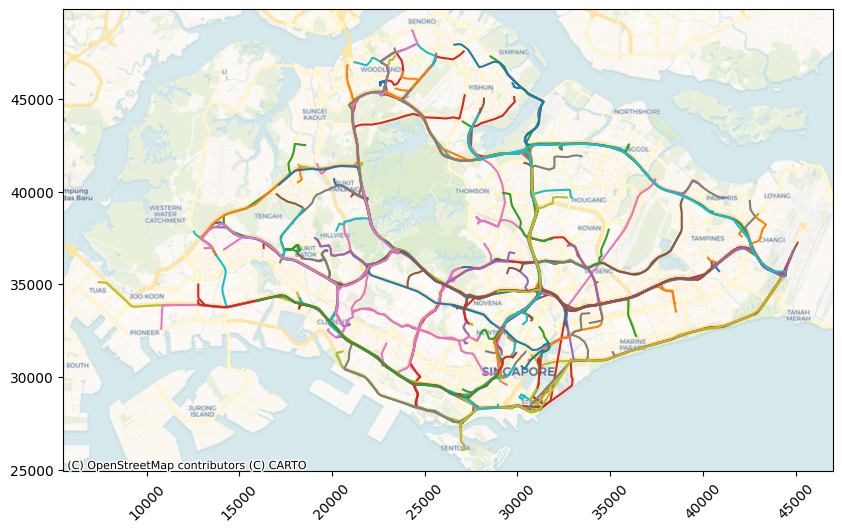

In [4]:
_, ax = plt.subplots(figsize=(12, 6))
_ = TemporalPointSequencePlotter.plot_sequences_xy(trajectories['Trajectory'], axes=ax, show_markers=False, show_grid=False)
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)

In this demo we will work over the ferries that do the route Rodby (Denmark) <-> Puttgarden (Germany), so we'll start creating a bounding box for each port.
We start by manually getting two points, one for each port, and creating a box for each. Then, we expand this bounding boxes.
From these two boxes we create another one that contains both. We'll use this bigger one ase a prefilter to detect the ferries.

In [8]:
# TODO: Change text above
bay = shp.set_srid(shp.Point(32232.5740, 30189.7942), 3414)
airport = shp.set_srid(shp.Point(44452.1091, 35088.7227), 3414)

bay_bb = STBox.from_geometry(bay).expand(1000)
airport_bb = STBox.from_geometry(airport).expand(1000)

joined = bay_bb.expand(airport_bb).expand(100)

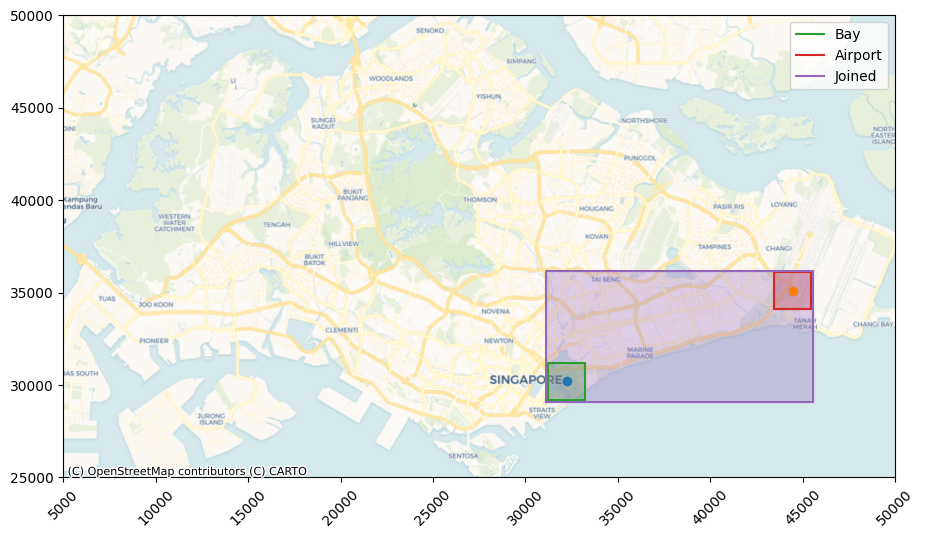

In [9]:
_, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim(25000, 50000)
ax.set_xlim(5000, 50000)
_ = ax.plot(bay.x, bay.y, marker="o")
_ = ax.plot(airport.x, airport.y, marker="o")
_ = bay_bb.plot_xy(axes=ax, label='Bay')
_ = airport_bb.plot_xy(axes=ax, label='Airport')
_ = joined.plot_xy(axes=ax, label='Joined')
_ = cx.add_basemap(ax, crs=3414, source=cx.providers.CartoDB.Voyager)
_ = plt.legend()